
# Setup


## Imports


In [ ]:
%load_ext autoreload

In [2]:
%autoreload 2

from functools import partial
import logging
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from typing import *
import time
import yaml
from yaml import YAMLObject

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import losses

from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import VolumeCropSequence, MetaCrop3DGenerator, ET3DUniformCuboidAlmostEverywhere, UniformGridPosition, GTUniformEverywhere, ET3DConstantDisplacementEverywhere, VSConstantEverywhere, GTConstantEverywhere, SequentialGridPosition
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel

In [3]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())
logger.info(f"{runid=}")

INFO::tomo2seg::{<ipython-input-3-cf972d05bc84>:<module>:004}::[2020-11-19::17:02:57.226]
runid=1605801777



In [4]:
logger.setLevel(logging.DEBUG)

In [5]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  

DEBUG::tomo2seg::{<ipython-input-5-05ac3d1186aa>:<module>:001}::[2020-11-19::17:02:57.364]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-5-05ac3d1186aa>:<module>:002}::[2020-11-19::17:02:57.472]
Num GPUs Available: 2
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-5-05ac3d1186aa>:<module>:003}::[2020-11-19::17:02:57.816]
Both here should return 2 devices...
tf.config.list_physical_devices('GPU')=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
tf.config.list_logical_devices('GPU')=[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Data

In [6]:
from tomo2seg.datasets import (
    VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
#     VOLUME_PRECIPITATES_DRYRUN_VAL as VOLUME_NAME_VERSION
)
# LABELS_VERSION = None

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=} {volume_version=} {labels_version=}")

INFO::tomo2seg::{<ipython-input-6-3d8694e42a81>:<module>:011}::[2020-11-19::17:02:57.884]
volume_name='PA66GF30' volume_version='v1' labels_version='refined3'



In [7]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=volume.metadata.dimensions,
        verbose=True,
    )

read_raw = partial(_read_raw, volume_=volume)

logger.info("Loading data from disk.")

## Data
voldata = read_raw(volume.data_path) / 255  # normalize
logger.debug(f"{voldata.shape=}")

voldata_train = volume.train_partition.get_volume_partition(voldata)
voldata_val = volume.val_partition.get_volume_partition(voldata)
logger.debug(f"{voldata_train.shape=} {voldata_val.shape=}")

del voldata

## Labels
vollabels = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{vollabels.shape=}")

vollabels_train = volume.train_partition.get_volume_partition(vollabels)
vollabels_val = volume.val_partition.get_volume_partition(vollabels)
logger.debug(f"{vollabels_train.shape=} {vollabels_val.shape=}")

del vollabels

DEBUG::tomo2seg::{data.py:with_check:217}::[2020-11-19::17:02:57.936]
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

ERROR::tomo2seg::{data.py:with_check:235}::[2020-11-19::17:02:57.938]
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels.raw

Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.weights.raw

DEBUG::tomo2seg::{data.py:metadata:174}::[2020-11-19::17:02:57.940]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

INFO::tomo2seg::{<ipython-input-7-3d9af8b98d34>:<module>:007}::[2020-11-19::17:02:57.946]
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [0, 1300], 'alias': 'train'}, 'val': {'x_range': [0, 1300], 'y_rang

## Data Sequences

In [8]:
batch_size_per_replica = 16  
batch_size = batch_size_per_replica * (n_replicas := strategy.num_replicas_in_sync)
logger.info(f"{batch_size_per_replica=}\n{n_replicas=}\n{batch_size=}")

common_random_state = 42
crop_shape = (224, 224, 1)  # multiple of 16 (requirement of a 4-level u-net)

# train volume
volume_shape_train = voldata_train.shape
crop_xyz_ranges_train = {
    "x_range": (0, volume_shape_train[0] - crop_shape[0] + 1),
    "y_range": (0, volume_shape_train[1] - crop_shape[1] + 1),
    "z_range": (0, volume_shape_train[2] - crop_shape[2] + 1),
}
logger.debug(f"{crop_xyz_ranges_train=}")

crop_seq_train = VolumeCropSequence(
    data_volume=voldata_train,
    labels_volume=vollabels_train,
    labels=volume.metadata.labels,
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=volume_shape_train,
        crop_shape=crop_shape,
        x0y0z0_generator=UniformGridPosition(
            random_state=RandomState(common_random_state),
            **crop_xyz_ranges_train,
        ),
        elastic_transformation_field=ET3DConstantDisplacementEverywhere.build(None, **crop_xyz_ranges_train),
        geometric_transformation_field=GTUniformEverywhere(
            random_state=RandomState(common_random_state),
            gt_type=volume_sequence.GT2D,
            **crop_xyz_ranges_train,
        ),
        value_shift_field=VSConstantEverywhere.build(0, **crop_xyz_ranges_train),
    ),
    batch_size=batch_size,
    # this volume cropper only returns random crops, 
    #so the number of crops per epoch/batch is w/e i want
    epoch_size=100,
    meta_crops_hist_path=None,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
)

# val volume

volume_shape_val = voldata_val.shape
crop_xyz_ranges_val = {
    "x_range": (0, volume_shape_val[0] - crop_shape[0] + 1),
    "y_range": (0, volume_shape_val[1] - crop_shape[1] + 1),
    "z_range": (0, volume_shape_val[2] - crop_shape[2] + 1),
}
crop_xyz_steps_val = {
    "x_step": 269,  # 1076 / 4, obs: 1076 % 4 == 0
    "y_step": 204,  # 816 / 4, obs: 816 % 4 == 0
    "z_step": 5,
}
logger.debug(f"{crop_xyz_ranges_val=}")

crop_seq_val = VolumeCropSequence(
    data_volume=voldata_val,
    labels_volume=vollabels_val,
    labels=volume.metadata.labels,
    meta_crop_generator = MetaCrop3DGenerator(
        volume_shape=volume_shape_val,
        crop_shape=crop_shape,
        x0y0z0_generator = (grid_position_generator_val := SequentialGridPosition(**crop_xyz_ranges_val, **crop_xyz_steps_val)),
        elastic_transformation_field=ET3DConstantDisplacementEverywhere.build(None, **crop_xyz_ranges_val),
        geometric_transformation_field=GTConstantEverywhere.build(volume_sequence.GT2D.identity, **crop_xyz_ranges_val,),
        value_shift_field=VSConstantEverywhere.build(0, **crop_xyz_ranges_val),
    ),
    batch_size=batch_size,
    # this volume cropper only returns random crops, 
    #so the number of crops per epoch/batch is w/e i want
    epoch_size=len(grid_position_generator_val),
    meta_crops_hist_path=None,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
)

INFO::tomo2seg::{<ipython-input-8-894381cd0b46>:<module>:003}::[2020-11-19::17:03:11.045]
batch_size_per_replica=16
n_replicas=2
batch_size=32

DEBUG::tomo2seg::{<ipython-input-8-894381cd0b46>:<module>:015}::[2020-11-19::17:03:11.047]
crop_xyz_ranges_train={'x_range': (0, 1076), 'y_range': (0, 816), 'z_range': (0, 1299)}

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:645}::[2020-11-19::17:03:11.048]
Initializing VolumeCropSequence.

No meta crops history file path given. The randomly generated crops will not be saved!

DEBUG::tomo2seg::{<ipython-input-8-894381cd0b46>:<module>:057}::[2020-11-19::17:03:11.050]
crop_xyz_ranges_val={'x_range': (0, 1076), 'y_range': (0, 816), 'z_range': (0, 299)}

INFO::tomo2seg::{volume_sequence.py:__post_init__:161}::[2020-11-19::17:03:11.052]
The SequentialGridPosition has len(self.positions)=960 different positions (therefore crops).

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:645}::[2020-11-19::17:03:11.053]
Initializing VolumeCropSequence

# Model

In [9]:
del tomo2seg_model

NameError: name 'tomo2seg_model' is not defined

In [10]:
from cnn_segm import keras_custom_loss

In [11]:
model_master_name = "unet-2d"
model_version = "vanilla00"
model_factory_function = modular_unet.u_net
model_factory_kwargs = dict(
    input_shape = crop_shape,
    nb_filters_0 = 6,
)

try:
    tomo2seg_model
    
except NameError:
    
    tomo2seg_model = Tomo2SegModel(
        model_master_name, model_version, 
        runid=runid,
        factory_function=model_factory_function,
        factory_kwargs=model_factory_kwargs,
    )
                
else:
    logger.warning("The model is already defined. To create a new one: `del tomo2seg_model`")

finally:
    logger.info("Compiling model.")
    
    with strategy.scope():
        if not tomo2seg_model.autosaved_model_path.exists():
#             assert not tomo2seg_model.model_path.exists(), f"Please delete '{tomo2seg_model.model_path}' to resave it if you wish to regenerate it."
            model = model_factory_function(
                output_channels=len(volume.metadata.labels), 
                name=tomo2seg_model.name,
                **model_factory_kwargs
            )
        else:
            logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
            model = keras.models.load_model(tomo2seg_model.autosaved_model_path_str)
       
        optimizer = optimizers.Adam()
        loss_func = keras_custom_loss.jaccard2_loss

        model.compile(loss=loss_func, optimizer=optimizer)
        model.save(tomo2seg_model.model_path)
    

logger.info(f"{tomo2seg_model}")

INFO::tomo2seg::{<ipython-input-11-1118c3a448a0>:<module>:025}::[2020-11-19::17:03:43.607]
Compiling model.

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/

In [12]:
# write the model summary in a file
with tomo2seg_model.summary_path.open("w") as f:
    def print_to_txt(line):
        f.writelines([line + "\n"])
    model.summary(print_fn=print_to_txt, line_length=140)
    
# same for the architecture
utils.plot_model(model, show_shapes=True, to_file=tomo2seg_model.architecture_plot_path);

logger.info(f"Check the summary and the figure of the model in the following locations:\n{tomo2seg_model.summary_path}\n{tomo2seg_model.architecture_plot_path}")

INFO::tomo2seg::{<ipython-input-12-1a966c379837>:<module>:010}::[2020-11-19::17:04:02.797]
Check the summary and the figure of the model in the following locations:
/home/users/jcasagrande/projects/tomo2seg/data/models/unet-2d.vanilla00.000.1605-801-777/summary.txt
/home/users/jcasagrande/projects/tomo2seg/data/models/unet-2d.vanilla00.000.1605-801-777/architecture.png



# Callbacks

In [18]:
autosave_cb = callbacks.ModelCheckpoint(
    tomo2seg_model.autosaved_model_path_str, 
    monitor="val_loss", 
    verbose=0, 
    save_best_only=True, 
    mode="auto",
)


logger_cb = callbacks.CSVLogger(
    str(tomo2seg_model.logger_path), separator=",", append=False  # todo change this to append !!! i lost it
)

# Summary before training

stuff that i use after the training but i want it to appear in the 


## Metadata

todo put this back to work

## Volume slices

todo put this back to work

## Generator samples

todo put this back to work

# Learning rate range test

todo put this back to work


# Training


In [19]:
# model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

In [20]:
from tensorflow.keras import backend as K

lr = 0.001
K.set_value(model.optimizer.learning_rate, lr)

cbs = [
    autosave_cb,
    logger_cb,
    callbacks.TerminateOnNaN(),
]

In [21]:
histories = []

In [22]:
history = model.fit(
    x=crop_seq_train,
    validation_data=crop_seq_val,
    epochs=30,  
    callbacks=cbs,  
    verbose=10,
    use_multiprocessing=False,   
    initial_epoch=0,
)
histories.append(history)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


In [28]:
history = model.fit(
    x=crop_seq_train,
    validation_data=crop_seq_val,
    epochs=30,  
    callbacks=cbs,  
    verbose=2,
    use_multiprocessing=False,   
    initial_epoch=0,
)
histories.append(history)

Epoch 1/30
100/100 - 128s - loss: 0.0158 - val_loss: 0.0151
Epoch 2/30
100/100 - 127s - loss: 0.0156 - val_loss: 0.0154
Epoch 3/30
100/100 - 128s - loss: 0.0156 - val_loss: 0.0151
Epoch 4/30
100/100 - 127s - loss: 0.0155 - val_loss: 0.0151
Epoch 5/30
100/100 - 127s - loss: 0.0156 - val_loss: 0.0153
Epoch 6/30
100/100 - 128s - loss: 0.0155 - val_loss: 0.0149
Epoch 7/30
100/100 - 127s - loss: 0.0153 - val_loss: 0.0152
Epoch 8/30
100/100 - 128s - loss: 0.0154 - val_loss: 0.0148
Epoch 9/30
100/100 - 127s - loss: 0.0152 - val_loss: 0.0155
Epoch 10/30
100/100 - 128s - loss: 0.0154 - val_loss: 0.0148
Epoch 11/30
100/100 - 127s - loss: 0.0153 - val_loss: 0.0150
Epoch 12/30
100/100 - 127s - loss: 0.0152 - val_loss: 0.0148
Epoch 13/30
100/100 - 127s - loss: 0.0151 - val_loss: 0.0146
Epoch 14/30
100/100 - 127s - loss: 0.0151 - val_loss: 0.0147
Epoch 15/30
100/100 - 127s - loss: 0.0151 - val_loss: 0.0146
Epoch 16/30
100/100 - 127s - loss: 0.0151 - val_loss: 0.0147
Epoch 17/30
100/100 - 128s - loss

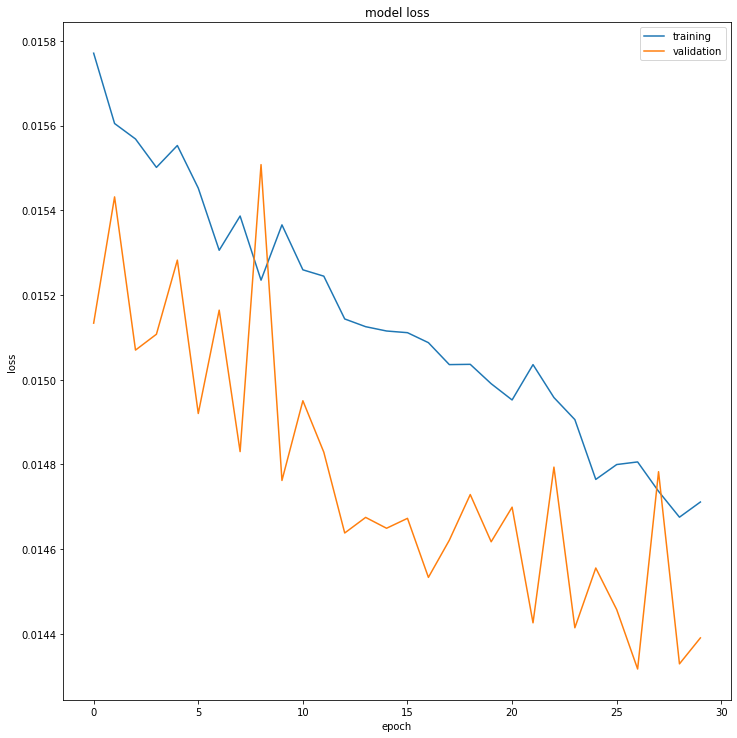

In [29]:
history = histories[1]
plt.subplots(figsize=(10,10))
plt.tight_layout()
viz.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 111)

In [43]:
from collections import defaultdict

merged_history = defaultdict(list)

for h in histories:
    for k in h.history.keys():
        merged_history[k].extend(h.history[k])
    merged_history['epoch'].extend(h.epoch)
    
merged_history = dict(merged_history)

In [45]:
history_df = pd.DataFrame(merged_history).set_index("epoch")
history_df.to_csv("temp-hist.csv", index=False)

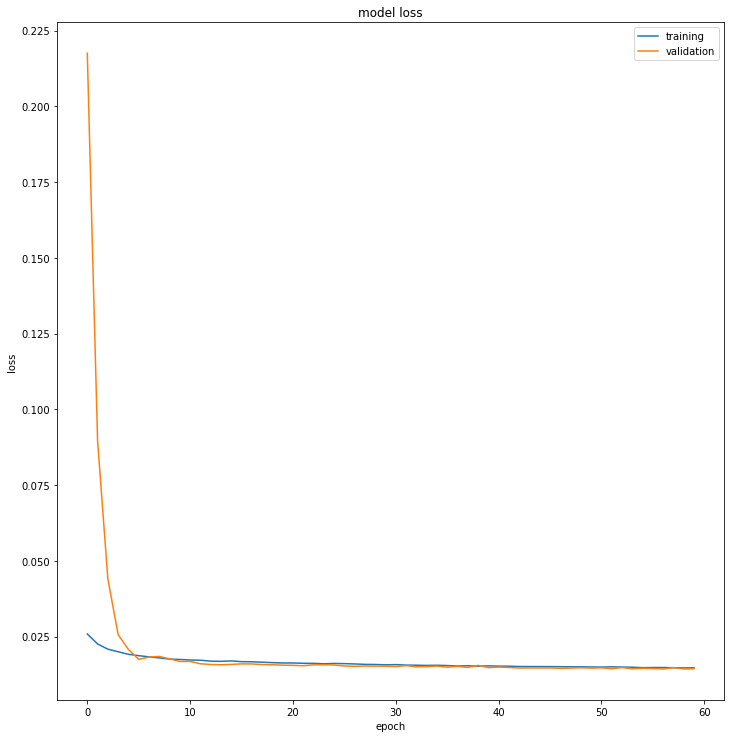

In [47]:
history = merged_history
plt.subplots(figsize=(10,10))
plt.tight_layout()
viz.display_training_curves(history['loss'], history['val_loss'], 'loss', 111)

In [30]:
model.save(tomo2seg_model.model_path)

INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/data/models/unet-2d.vanilla00.000.1605-801-777/assets
